In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts


###  Reading in relevant data

Reading in BH position data from Corral-Santan et al 2016. (https://www.aanda.org/articles/aa/abs/2016/03/aa27130-15/aa27130-15.html)

In [2]:
df=pd.read_csv('Corral_data_simplified.csv')


Reading in SNR position/radius data from Green et al 2014 (http://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html)
Note that elliptical SNRs have an average radius reported.

In [3]:
df_SNRs=pd.read_csv('Green_Catalog_SNRs.csv')


Here's what it looks like:

In [4]:
df.head(5)


year                  object           RA           Dec         l       b  \
0  2014         IGR J17454-2919  17 45 27.69  -29 19 53.83  359.6444 -0.1765   
1  2014         IGR J17451-3022  17 45 06.72  -30 22 43.30  358.7115 -0.6580   
2  2013          MAXI J1828-249  18 28 58.07  -25 01 45.88    8.1145 -6.5458   
3  2013      SWIFT J1753.7-2544  17 53 39.85  -25 45 14.20    3.6476  0.1036   
4  2012  SWIFT J174510.8-262411  17 45 10.85  -26 24 12.60    2.1107  1.4034   

  distance distance error                                            Refs  
0      NaN            NaN                         Chenevez2014,Paizis2015  
1      NaN            NaN                   Chenevez2014b,Chakrabarty2014  
2      NaN            NaN                        Nakahira2013,Kennea2013a  
3      NaN            NaN                               Krimm2013,Rau2013  
4       <7              :  Cummings2012,Miller-Jones2012,Munoz-Darias2013

In [5]:
df_SNRs.head()


Lon  Lat  av Rad
0  0.0  0.0     3.0
1  0.3  0.0    11.5
2  0.9  0.1     8.0
3  1.0 -0.1     8.0
4  1.4 -0.1    10.0

Putting the longitudes into a (-180,180) coordinate system for ease of fitting

In [6]:
df['l_180'] = df.apply(
    lambda row: ((row.l +180) % 360) -180,
    axis=1
)


In [7]:
df_SNRs['Lon_180'] = df_SNRs.apply(
    lambda row: ((row.Lon + 180) % 360) -180,
    axis=1
)


Here's the Milky Way Galxy, as we know it:

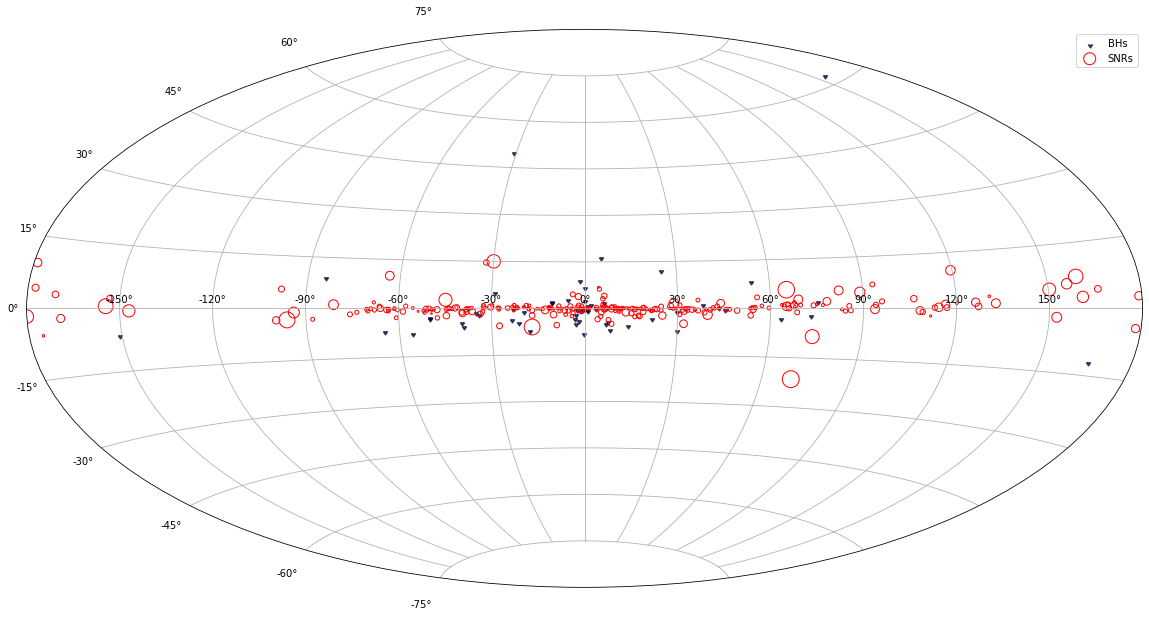

In [77]:
#For skyplott
#import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

gal_BH = SkyCoord(df['l_180'], df['b'], frame='galactic', unit=u.deg)
gal_SNR = SkyCoord(df_SNRs['Lon_180'], df_SNRs['Lat'], frame='galactic', unit=u.deg)

plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

plt.scatter(gal_BH.l.wrap_at('180d').radian,gal_BH.b.radian,marker=11,s=20,color='#000033',alpha=0.7,label='BHs')
plt.scatter(gal_SNR.l.wrap_at('180d').radian,gal_SNR.b.radian,s=df_SNRs['av Rad'], facecolors='none', edgecolors='r',label='SNRs')
plt.legend()

plt.show()


### Now some tools for fitting and resampling the data:

In [262]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


def kde(x,
        x_grid,
        bandwidth=5.0,
        **kwargs
       ):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def generate_rand_from_pdf(pdf,
                           x_grid,
                           number
                          ):
    """ """
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1] 
    values = np.random.rand(number)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf


def take_data_return_resample(data,
                              bins,
                              xmin,
                              xmax,
                              label='label',
                              bandwidth=5.0,
                              number_of_samples=1000,
                              show_plots=True):

    x_grid = np.linspace(xmin, xmax, 10000)
    delta_x= x_grid[2]-x_grid[1]
    
    kdepdf = kde(data,
                 x_grid,
                 bandwidth=bandwidth
                ) # creating a kde from the data
    random_from_kde = generate_rand_from_pdf(kdepdf,
                                             x_grid,
                                             number_of_samples
                                            ) + (np.random.rand(number_of_samples)-0.5)*2*delta_x
                                            # sampling the generated kde and adding random number within each band
    
    if show_plots == True :
        fig= plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.hist(data, bins, density=True, alpha=0.5, label=label+' (real)')
        plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label=label+' (kde)')
        plt.title("Fitting to the Galactic distribution")
        plt.xlim(xmin,xmax)
        plt.legend()

        plt.subplot(122)
        plt.hist(random_from_kde, bins, alpha=0.5, label=label+' (artificial)',color='purple')
        plt.legend()
        plt.xlim(xmin,xmax)
        plt.title("Sampling from a Galactic-like distribution")
        plt.show()

    return random_from_kde


def battleships(NoSNRs,
                NoBHlmxb,
                BH_lon,
                SNR_lon,
                BH_lat,
                SNR_lat,
                SNR_rad
               ):
    """Checking for Overlap between BHs and SNRs"""
    AllHits = [] 
    for s in range (0,NoSNRs):
        for b in range (0,NoBHlmxb):
            displacement=np.sqrt((BH_lon[b]-SNR_lon[s])**2+(BH_lat[b]-SNR_lat[s])**2)
            
            if displacement <= (1.0/3.0)*SNR_rad[s]:
                Hit=1
                print('   ---Hit...',BH_lon[b],SNR_lon[s],BH_lat[b],SNR_lat[s],SNR_rad[s])
            else:
                Hit=0               
            AllHits.append(Hit) #adding up hits
    return sum(AllHits)



## Showing how we resample the BH and SNR distributions:

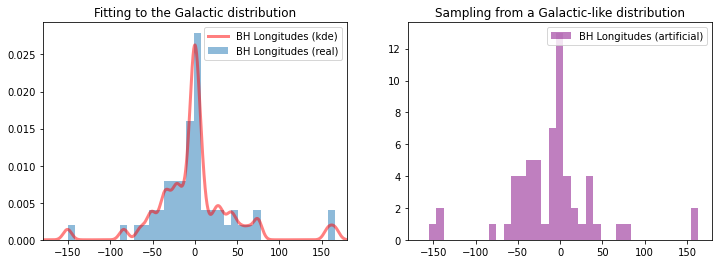

In [266]:
BH_longs = take_data_return_resample(df['l_180'], 36, -180, 180, label='BH Longitudes',bandwidth=5,number_of_samples=60)

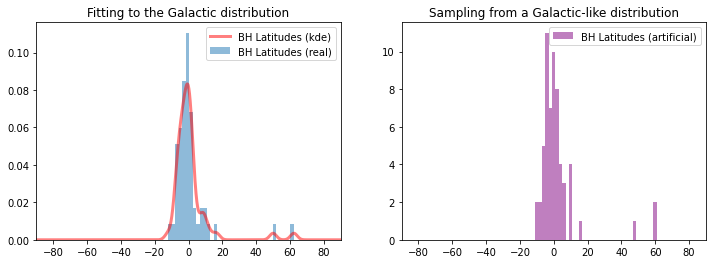

In [113]:
BH_lats = take_data_return_resample(df['b'], 36, -90, 90, label='BH Latitudes',bandwidth=2,number_of_samples=60)


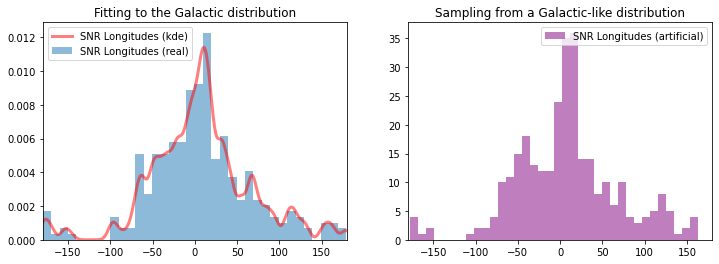

In [104]:
SNR_longs = take_data_return_resample(df_SNRs['Lon_180'], 36, -180, 180, label='SNR Longitudes',bandwidth=5,number_of_samples=300)


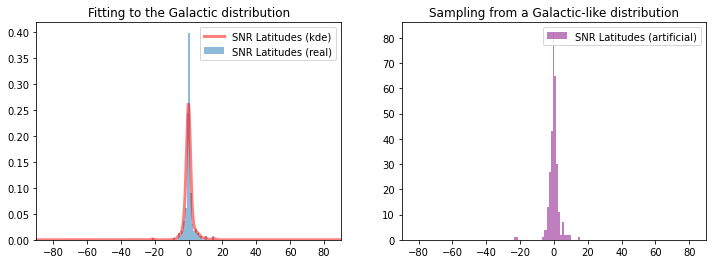

In [105]:
SNR_lats = take_data_return_resample(df_SNRs['Lat'], 36, -90, 90, label='SNR Latitudes',bandwidth=1,number_of_samples=300)


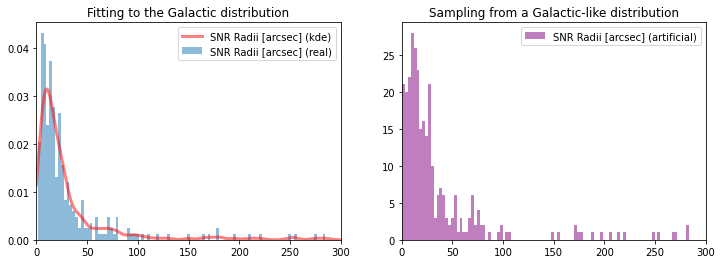

In [72]:
SNR_Rad = take_data_return_resample(df_SNRs['av Rad'], 100, 0, 300, label='SNR Radii [arcsec]',bandwidth=5,number_of_samples=300)


# Now to generate an ensemble of simulated Milky Way-like galaxies

In [294]:
GalNo=100000 # How many Galaxies to build

No_BHs=60
No_SNRs=300


In [298]:
#Counters
TotalHits_OneGal=0
TotalHits_AllGal=0

#looping over Galaxies
for j in range(0,GalNo):

    #Generate BHs and SNRs
    BH_lon = take_data_return_resample(df['l_180'], 
                                      36, 
                                      -180, 
                                      180, 
                                      'BH Longitudes',
                                      bandwidth=5,
                                      number_of_samples=60,
                                      show_plots=False
                                      )
    BH_lat = take_data_return_resample(df['b'],
                                       36,
                                       -90,
                                       90,
                                       label='BH Latitudes',
                                       bandwidth=3,
                                       number_of_samples=60,
                                       show_plots=False
                                      )

    SNR_lon = take_data_return_resample(df_SNRs['Lon_180'],
                                        36,
                                        -180,
                                        180,
                                        label='SNR Longitudes',
                                        bandwidth=5,
                                        number_of_samples=300,
                                        show_plots=False
                                       )
    SNR_lat = take_data_return_resample(df_SNRs['Lat'],
                                        36,
                                        -90,
                                        90,
                                        label='SNR Latitudes',
                                        bandwidth=1,
                                        number_of_samples=300,
                                        show_plots=False
                                        )
    SNR_rad = take_data_return_resample(df_SNRs['av Rad'],
                                        100,
                                        0,
                                        300,
                                        label='SNR Radii [arcsec]',
                                        bandwidth=5,
                                        number_of_samples=300,
                                        show_plots=False
                                       )


    #Examine Overlap.  NoSNRs, NoBHlmxb, BH_lon, SNR_lon, BH_lat, SNR_lat, SNR_rad
    TotalHits_OneGal = battleships(No_SNRs, No_BHs, BH_lon, SNR_lon, BH_lat, SNR_lat, (1.0/3600.0)*SNR_rad)


    TotalHits_AllGal = TotalHits_AllGal + TotalHits_OneGal


    if ((j+1)%1000) == 0 : print('Galaxy no. ',j+1,', total hits so far = ',TotalHits_AllGal)



TotalBHs=GalNo*No_BHs
Prob=(TotalHits_AllGal/TotalBHs)*100.0



print('Out of ',GalNo,' Galaxies and ',TotalBHs,' BHs, there were ',TotalHits_AllGal,' instances of near-centre overlap')
print('Chance probability of coiincidence is ',Prob,'%')


   ---Hit... 10.901730647559303 10.915779636674518 1.0547229661984385 1.0638868319547679 0.0788126039614053
Galaxy no.  1000 , total hits so far =  1
   ---Hit... -8.492222805927582 -8.487119457052739 -0.4640337806136121 -0.46377893367102274 0.019084328938209466
   ---Hit... -23.77194728709812 -23.774311515637795 -1.4264500045097999 -1.4253801394528038 0.009510136537589664
Galaxy no.  2000 , total hits so far =  3
Galaxy no.  3000 , total hits so far =  3
Galaxy no.  4000 , total hits so far =  3
   ---Hit... 59.9214306312305 59.93084421063796 -0.549142556830815 -0.5602806850791144 0.0579769040085229
Galaxy no.  5000 , total hits so far =  4
Galaxy no.  6000 , total hits so far =  4
Galaxy no.  7000 , total hits so far =  4
Galaxy no.  8000 , total hits so far =  4
   ---Hit... -24.120852676029084 -24.12112560657175 -1.086609085344765 -1.0867374166457688 0.00502879865706664
Galaxy no.  9000 , total hits so far =  5
   ---Hit... -2.0845620370802207 -2.083898127092015 0.5067970000029675 

Galaxy no.  66000 , total hits so far =  49
   ---Hit... 10.543340567186402 10.559916451708885 0.22824569183500854 0.21026998657403323 0.07711053091484688
   ---Hit... 40.32164302165155 40.31750415675198 0.8705215799182918 0.870203868986807 0.013936228752113712
Galaxy no.  67000 , total hits so far =  51
Galaxy no.  68000 , total hits so far =  51
   ---Hit... -0.6199869933296923 -0.6173412245320514 0.7083538318536651 0.7063572540011995 0.01110219201424676
   ---Hit... -9.253153417766235 -9.251052767758603 0.4899888870035601 0.4758718321750802 0.051257688386727146
Galaxy no.  69000 , total hits so far =  53
Galaxy no.  70000 , total hits so far =  53
Galaxy no.  71000 , total hits so far =  53
Galaxy no.  72000 , total hits so far =  53
   ---Hit... 16.764560016505172 16.745571035251256 0.29753129901580994 0.2885630863445968 0.07624780532993443
Galaxy no.  73000 , total hits so far =  54
Galaxy no.  74000 , total hits so far =  54
   ---Hit... 4.315098563851509 4.316763028161182 0.4121

Now we have a BH-SNR chance overlap likelihood estimate 

# Now to visualise the final simulated Galaxy, as a sanity check

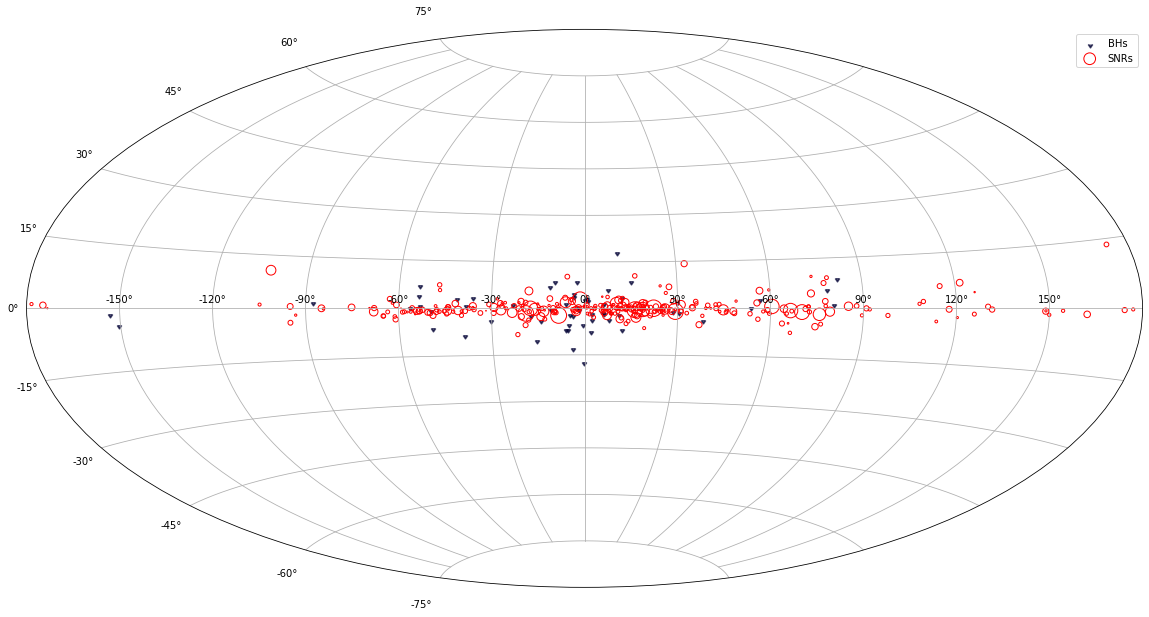

In [297]:
gal_BH = SkyCoord(BH_lon[:], BH_lat[:], frame='galactic', unit=u.deg)
gal_SNR = SkyCoord(SNR_lon[:], SNR_lat[:], frame='galactic', unit=u.deg)

plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

plt.scatter(gal_BH.l.wrap_at('180d').radian,gal_BH.b.radian,marker=11,s=20,color='#000033',alpha=0.7,label='BHs')
plt.scatter(gal_SNR.l.wrap_at('180d').radian,gal_SNR.b.radian,s=SNR_rad, facecolors='none', edgecolors='r',label='SNRs')
plt.legend()

plt.show()
